In [1]:
import json
import pickle
import pandas as pd
pd.options.display.max_colwidth = 200

import numpy as np
from numpy import mean
from collections import Counter
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
pwd

'/Users/rosamondthalken/Documents/Projects/SupremeCourt/SupremeCourtPython'

In [3]:
output_path = '/Users/rosamondthalken/Documents/Projects/SupremeCourt/SupremeCourtPython/Figures'

In [4]:
remove_per_curiam = False
if remove_per_curiam:
    input_path = "predictions_no_percur_df.p"
    
else:
    input_path = "predictions_df.pkl"

## Load dataframe

In [5]:
df = pd.read_pickle(input_path)

In [6]:
df.sample(10)

,opinion_num,category,author,case,year,text,sent_index,length,sent_location,percent_letter,predictions,prob_0,prob_1,monologic_prediction,sentence_length,chief_justice
1289258,12055,Majority,Justice Alito,Vance v. Ball State Univ.,2013,"And for this reason, petitioner’s argument, taken on its own terms, is unsuccessful.",158,364,0.434066,79.761905,"[0.9960116147994995, 0.003988446202129126]",0.996012,0.003988,0,84,Roberts
1747959,16574,Majority,Justice White,Scofield v. NLRB,1969,"In dealing with the employer as bargaining agent, the union has accorded all employees uniform treatment.",100,113,0.884956,83.809524,"[0.99803227186203, 0.0019677740056067705]",0.998032,0.001968,0,105,Warren
1631566,15398,Majority,Justice Brennan,Orr v. Orr,1979,"""Where the state court does not decide against a petitioner or appellant upon an independent state ground, but deeming the federal question to be before it, actually *277 entertains and decides th...",73,142,0.514085,80.654762,"[0.9910780787467957, 0.008921868167817593]",0.991078,0.008922,0,336,Burger
759780,7126,Majority,Justice O'Connor,Commodity Futures Trading Comm'n v. Schor,1986,"Schor expressly demanded that Conti proceed on its counterclaim in the reparations proceeding rather than before the District Court, see App.",189,298,0.634228,84.397163,"[0.9973691701889038, 0.0026308607775717974]",0.997369,0.002631,0,141,Burger
933862,8753,Majority,Justice Marshall,"Summit Valley Industries, Inc. v. Carpenters",1982,The District Court found that the Boards decision that the Union had committed unfair labor practices collaterally estopped the Union from relitigating this issue in the § 303 action.,39,130,0.300000,81.967213,"[0.997814416885376, 0.002185516059398651]",0.997814,0.002186,0,183,Burger
1505958,14171,Dissenting,Justice Ginsburg,Gray v. Netherland,1996,"1 Defense counsel wanted to know, in particular, whether the prosecutor planned to introduce evidence relating to the murders of Lisa Sorrell and her 3-year-old daughter, Shanta.",11,198,0.055556,80.898876,"[0.996981680393219, 0.0030183037742972374]",0.996982,0.003018,0,178,Rehnquist
1139164,10674,Majority,Justice Blackmun,Rogers v. Bellei,1971,"United States v. Wong Kim Ark, 169 U. S., at 688.",166,248,0.669355,55.102041,"[0.9954202771186829, 0.0045796772465109825]",0.995420,0.004580,0,49,Burger
1582578,14911,Dissenting,Justice Breyer,Uttecht v. Brown,2007,"Or, it simply offers a backdoor way to avoid the effect of Washingtons procedural rule.",13,20,0.650000,81.609195,"[0.995840847492218, 0.0041590784676373005]",0.995841,0.004159,0,87,Roberts
515064,4907,Majority,Justice Clark,American Automobile Assn. v. United States,1961,"It maintains, however, that Michigan does not control this case because of a difference in proof, i. e., that in this case the record contains expert accounting testimony indicating that the syste...",30,94,0.319149,81.722689,"[0.9977133274078369, 0.0022867152001708746]",0.997713,0.002287,0,476,Warren
324743,3162,Majority,Justice Brennan,Douglas v. Alabama,1965,"4 After the second time, the Solicitor *422 assured him that he already had an objection in, plainly implying that further objection to the reading of the document was unnecessary.",61,81,0.753086,79.444444,"[0.9965053796768188, 0.003494641510769725]",0.996505,0.003495,0,180,Warren


In [7]:
len(Counter(df.opinion_num))

16835

In [8]:
len(Counter(df.case))

8949

In [9]:
Counter(df.monologic_prediction)

Counter({1: 249169, 0: 1293089})

In [10]:
Counter(df.monologic_prediction)[1]/Counter(df.monologic_prediction)[0]

0.1926928463547366

# Analysis

## Ratio of monologic to non-monologic by opinion type

In [11]:
def plot_ratio(df):
    sns.set(style='ticks', font_scale=1.2)
    sns.set_palette(sns.color_palette("colorblind"))
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]}
        
    # box plot
    
    #plt.figure(figsize=(7,2.5))
    sns.barplot(data=df, 
                x="category", 
                y="monologic_prediction",
                estimator=mean,
                hue = "category",
                order=["Majority","Per Curiam", "Dissenting", "Concurring"],
                palette = palette,
                dodge=False
               )

    plt.xlabel('Category')
    plt.ylabel('Monologic Ratio')
    plt.title("Monologic Voice by Opinion Type")
    plt.tight_layout()
    sns.despine()
    plt.legend([],[], frameon=False)
    plt.savefig(output_path + '/by_opinion')
    plt.show()


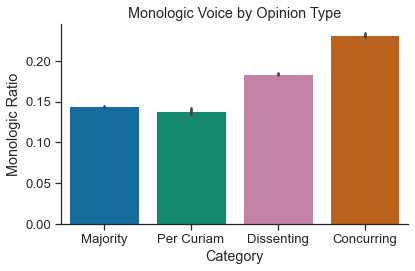

In [12]:
plot_ratio(df)

## Changes in monologic voice over the course of the opinion

In [13]:
def create_all_bins(df, bin_size, labels = True):
    if labels:
        df['bins'] = pd.cut(df["sent_location"], bin_size, labels = np.arange(0, bin_size, 1))
    
    else:
        df['bins'] = pd.cut(df["sent_location"], bin_number)
    mean_df = df[['bins', 'monologic_prediction']].groupby('bins').mean()
    mean_df['bins'] = mean_df.index
    
    return mean_df

In [14]:
mean_df = create_all_bins(df, 20)

In [15]:
mean_df.head(5)

,monologic_prediction,bins
bins,,
0,0.191610,0
1,0.112080,1
2,0.108610,2
3,0.118759,3
4,0.134088,4


In [16]:
def plot_sentences_over_opinion_time(df):
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(9,6))
    sns.barplot(data=df, 
                x="bins", 
                y="monologic_prediction",
                estimator=mean,
                color='cornflowerblue')
    plt.xticks([])

    plt.xlabel('Opinion Time')
    plt.ylabel('Monologic Concentration')
    plt.title("Monologic Voice Over Opinion Time")
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/all_over_time')
    plt.show()

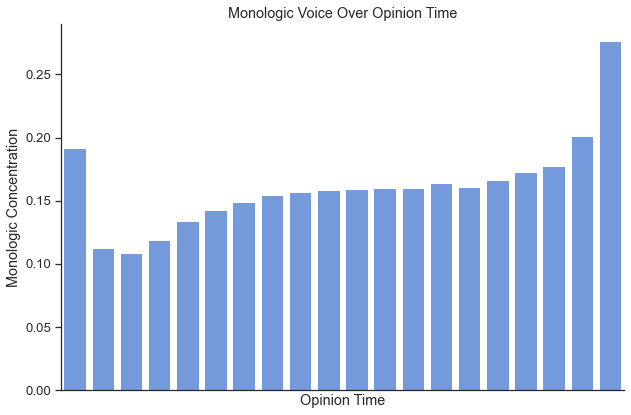

In [17]:
plot_sentences_over_opinion_time(mean_df)

In [18]:
def plot_sentences_by_case_type(df, bin_size):
    sns.set_palette(sns.color_palette("colorblind"))
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]} 

  # NOTE: create_all_bins is a function created outside of this function
    category_prediction_bins = df.groupby('category').apply(create_all_bins, bin_size)
    category_prediction_bins["category"] = category_prediction_bins.index.get_level_values(0)

    g = sns.FacetGrid(category_prediction_bins, 
                      col="category", 
                      col_wrap=2, 
                      hue = "category", 
                      height=5, 
                      col_order = ["Majority","Per Curiam", "Dissenting", "Concurring"],
                      palette=palette)
    g.map(sns.barplot, "bins", "monologic_prediction")
    g.set_titles(col_template="{col_name}")
    g.set(xticklabels=[])
    g.fig.subplots_adjust(top=0.88)
    g.fig.suptitle('Monologic Voice Over Opinion Time, by Category', fontsize = 20)
    plt.savefig(output_path + '/over_case_time_category')

  # add figure save

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


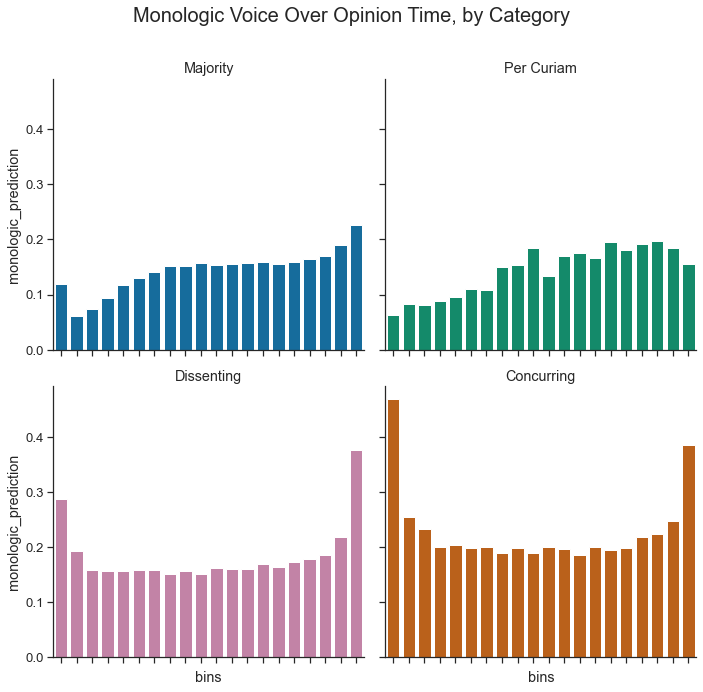

In [19]:
plot_sentences_by_case_type(df, 20)

## Monologic voice changes over years

In [20]:
def plot_sentences_over_years(df):
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(14,5))
    sns.lineplot(data=df,
                x="year", 
                y="monologic_prediction",
                estimator=mean, 
                color='cornflowerblue')

    # set xlim
    chief_years = [1946, 1953, 1969, 1986, 2005]
    chief_names = ["Vinson", "Warren", "Burger", "Rehnquist", "Roberts"]
    for y, n in zip(chief_years, chief_names):
        plt.axvline(y, color='0.8')
        plt.text(x=y+1, y=.21, s=n, alpha=0.7, color='#334f8d')
    plt.xticks(np.arange(1945, 2020, 5), rotation=90)
    plt.xlabel('Case Year')
    plt.ylabel('Monologic Concentration')
    plt.title("Monologic Voice Over Years", fontsize=20, y=1.08)
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/over_time')
    plt.show()

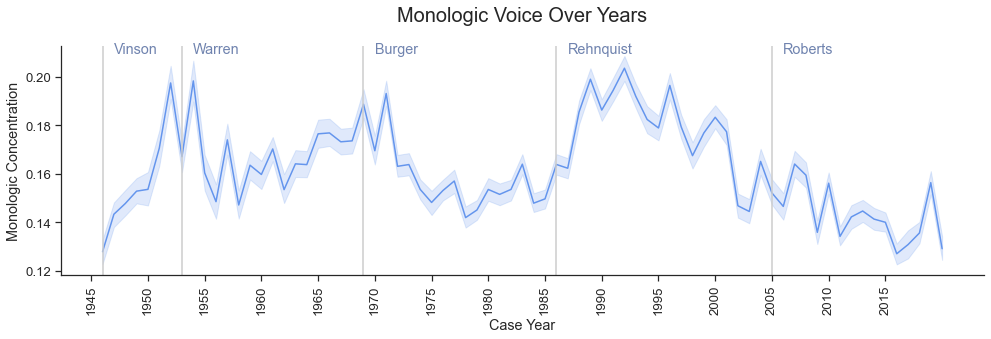

In [21]:
plot_sentences_over_years(df)

See whether or not the above trend can be explained by percentage of majority cases. Group by year, for each year plot the ratio of majority cases. 

In [22]:
# plot over years, faceted
def plot_sentences_over_years_category(df):
    
    sns.set_palette(sns.color_palette("colorblind"))
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]} 

    g = sns.FacetGrid(df, 
                      col="category", 
                      hue = "category", 
                      col_wrap=1, 
                      col_order = ["Majority","Per Curiam", "Dissenting", "Concurring"], 
                      palette=palette)
    
    g.fig.set_figheight(10)
    g.fig.set_figwidth(7)
    g.map(sns.lineplot, 
          "year", 
          "monologic_prediction", 
          estimator=mean)
    g.map(plt.axhline, y = 0.2,  ls=":", c=".5")
    g.set_titles(col_template="{col_name}")
    g.fig.subplots_adjust(top=0.88)
    g.fig.suptitle('Monologic voice over years, by category', fontsize = 16)
    
    # save plot
    plt.savefig(output_path + '/over_time_category')


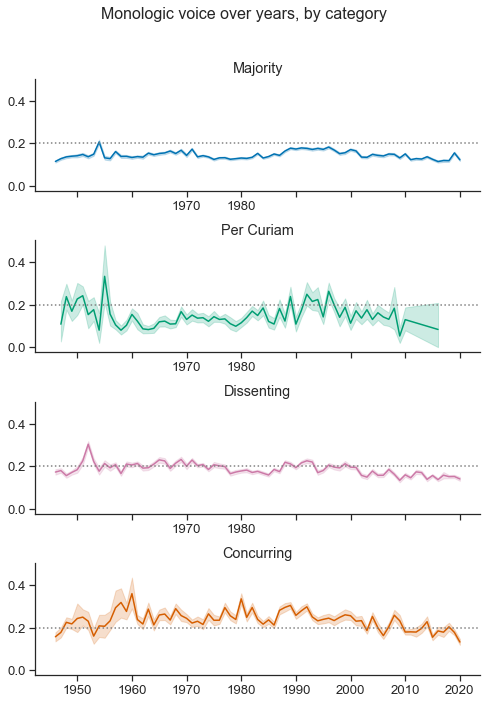

In [23]:
plot_sentences_over_years_category(df)

In [24]:
# Over years by author
# plot over years, faceted
def plot_sentences_over_years_by_author(df):
    
    g = sns.FacetGrid(df, 
                      col="author", 
                      #hue = "chief_justice", 
                      col_wrap=5,
                      sharex=False,
                      #col_order = ["Majority","Per Curiam", "Dissenting", "Concurring"], 
                      #palette=palette
                     )
    
    g.fig.set_figheight(50)
    g.fig.set_figwidth(70)

    g.map(sns.lineplot, 
          "year", 
          "monologic_prediction", 
          estimator=mean)
    g.map(plt.axhline, y = 0.2,  ls=":", c=".5")
    g.set_titles(col_template="{col_name}", fontsize = 30)
    g.fig.subplots_adjust(top=0.94)
    g.fig.suptitle('Monologic voice over years, by author', fontsize = 30)
    
    # save plot
    plt.savefig(output_path + '/over_time_justice')

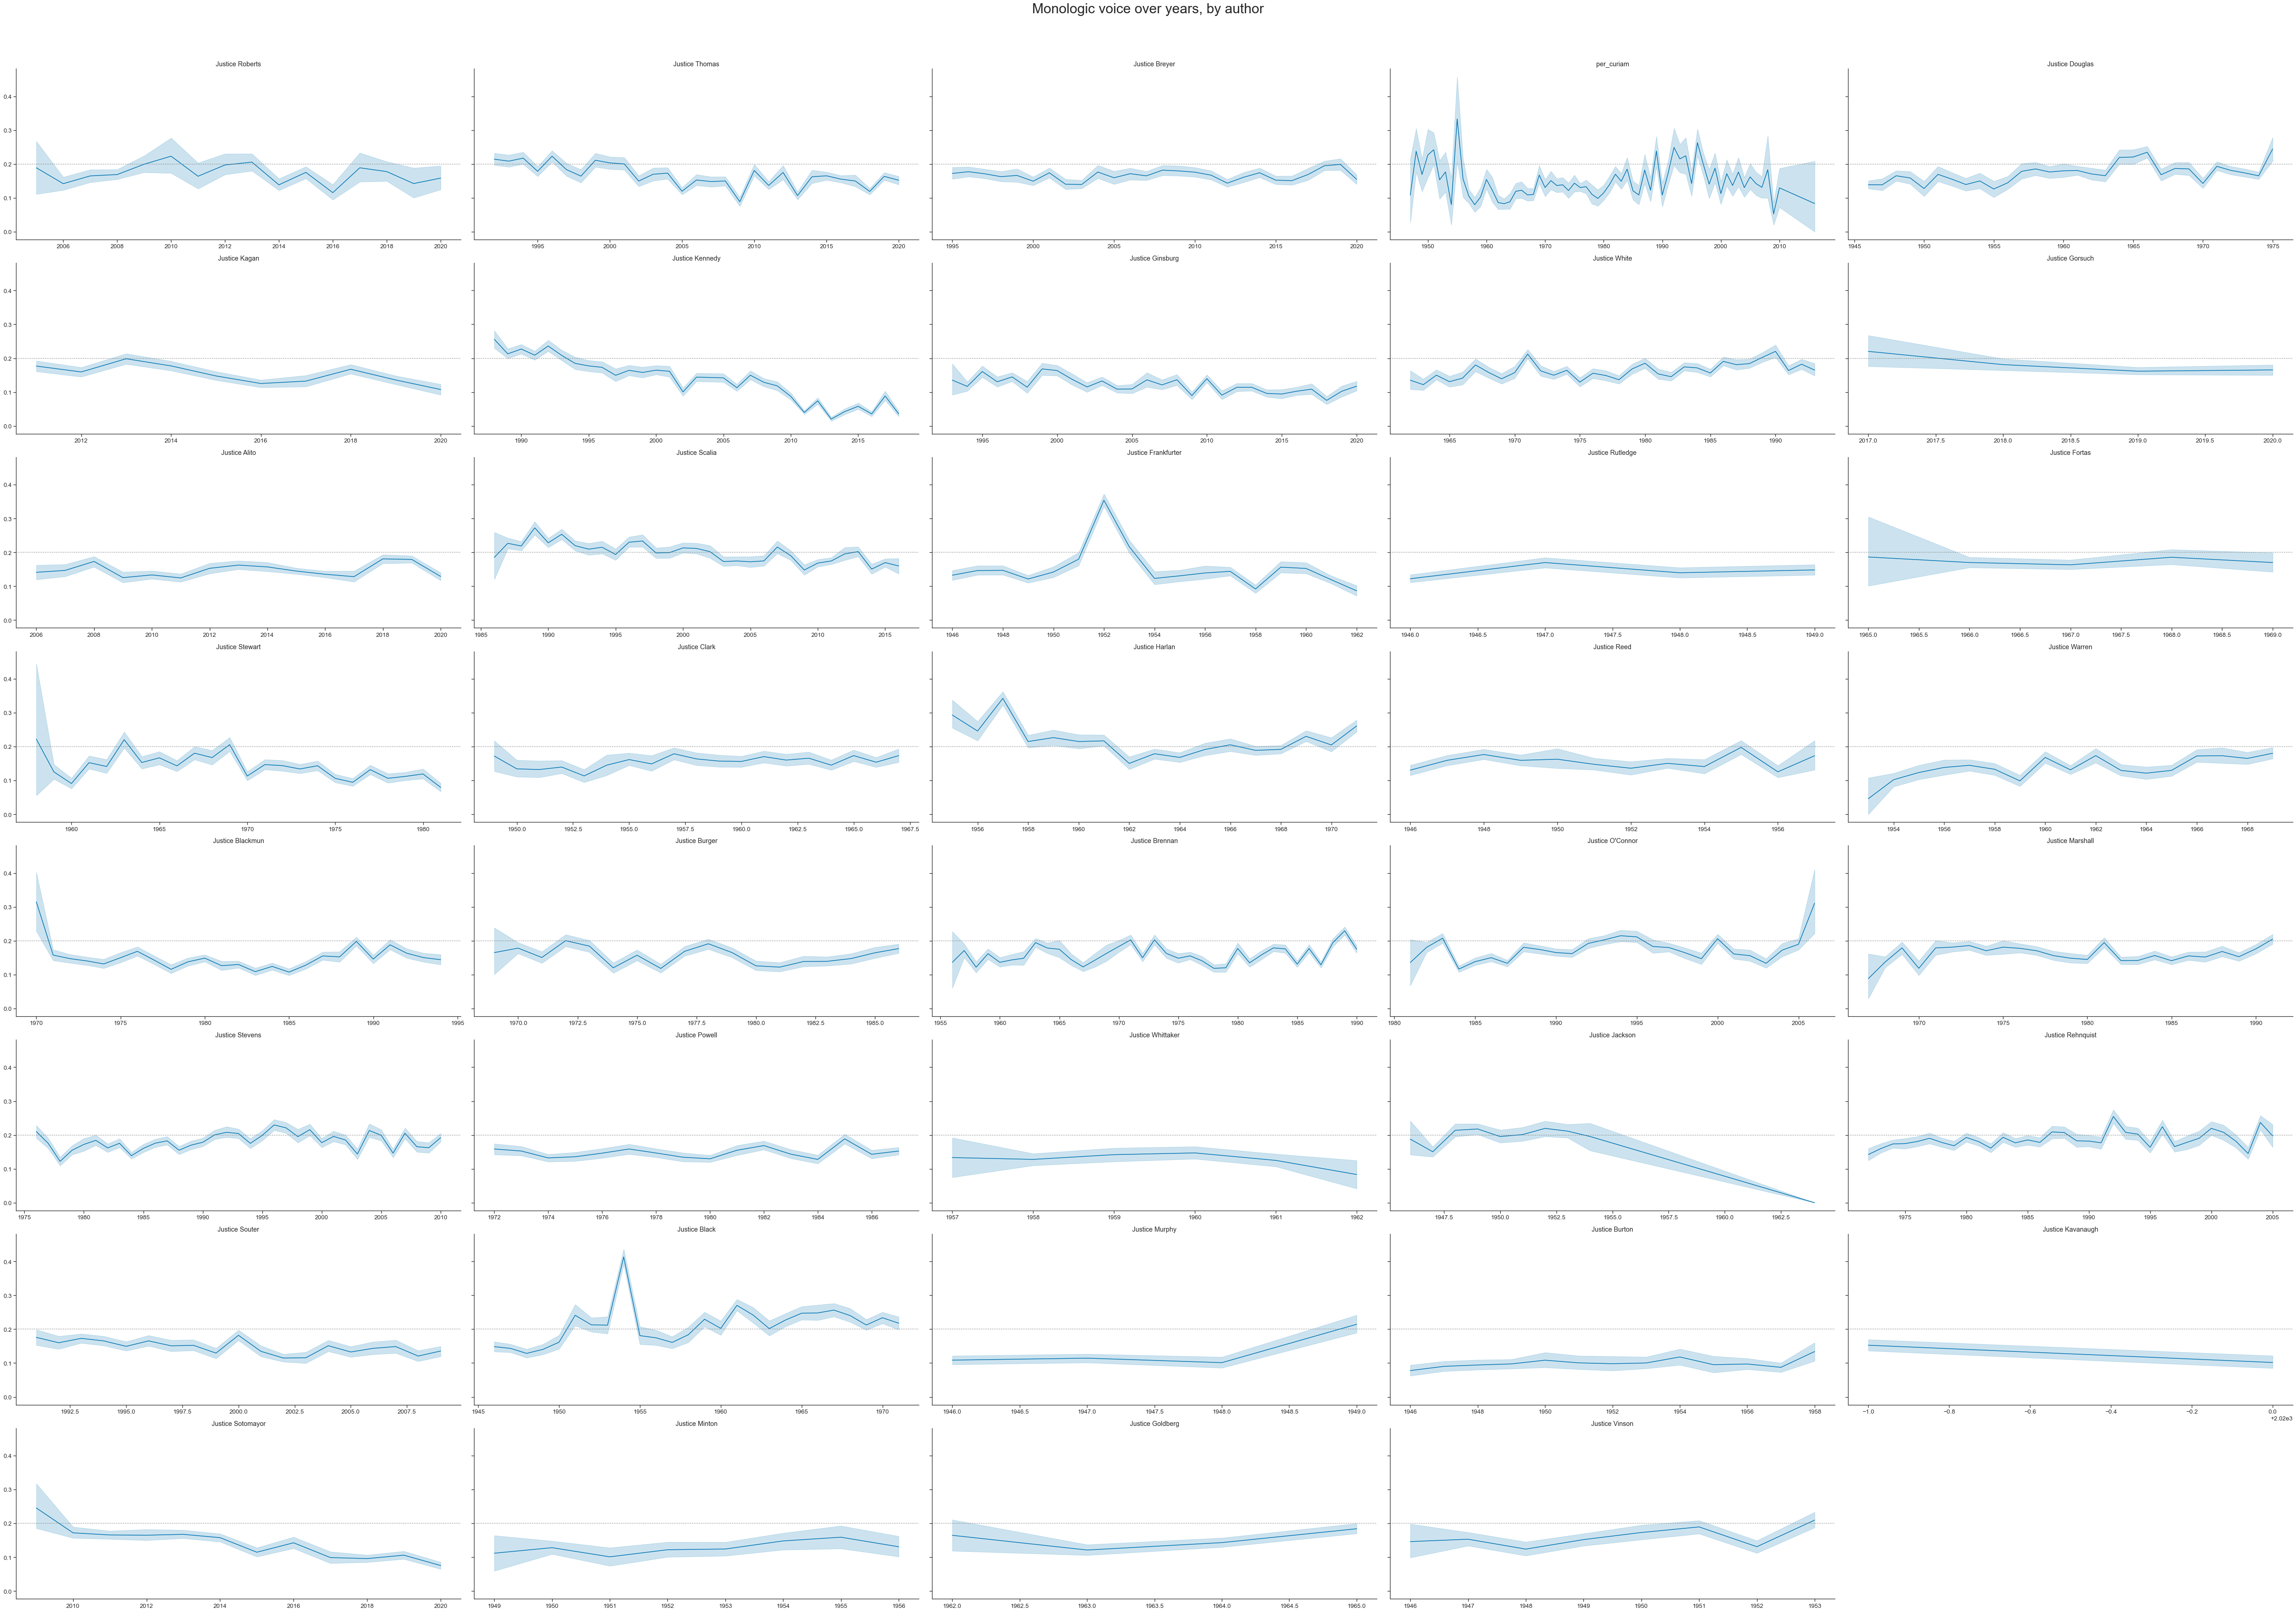

In [25]:
plot_sentences_over_years_by_author(df)

## Effect size between courts

In [26]:
per_opinion = df.groupby(['opinion_num', 'year'], as_index=False)['monologic_prediction'].mean()

In [27]:
# merge per opinion with metadata
vinson_court = per_opinion[per_opinion["year"] <= 1953]
warren_court = per_opinion[(per_opinion["year"] >= 1954) & (per_opinion["year"] <= 1968)]
burger_court = per_opinion[(per_opinion["year"] >= 1969) & (per_opinion["year"] <= 1985)]
rehnquist_court = per_opinion[(per_opinion["year"] >= 1986) & (per_opinion["year"] <= 2005)]
roberts_court = per_opinion[(per_opinion["year"] >= 2006)]

In [28]:
from statistics import mean, stdev
from math import sqrt

def cohens_d(values_1, values_2):
    cohens_d = (mean(values_1) - mean(values_2)) / (sqrt((stdev(values_1) ** 2 + stdev(values_2) ** 2) / 2))
    return cohens_d

In [29]:
print("Vinson <-> Warren: "+ str(cohens_d(warren_court["monologic_prediction"].to_list(), vinson_court["monologic_prediction"].to_list())))
print("Warren <-> Burger: "+ str(cohens_d(burger_court["monologic_prediction"].to_list(), warren_court["monologic_prediction"].to_list())))
print("Burger <-> Rehnquist: "+ str(cohens_d(rehnquist_court["monologic_prediction"].to_list(), burger_court["monologic_prediction"].to_list())))
print("Rehnquist <-> Roberts: "+ str(cohens_d(roberts_court["monologic_prediction"].to_list(), rehnquist_court["monologic_prediction"].to_list())))

Vinson <-> Warren: -0.16799830698117563
Warren <-> Burger: 0.26011546433456306
Burger <-> Rehnquist: 0.1709174888542103
Rehnquist <-> Roberts: -0.3346147550549798


## Percent of majority cases per year

In [30]:
test = df.groupby("year").category.count()

In [31]:
majority_df = df[df["category"]=="Majority"]
majority_count = majority_df.groupby("year").category.count()

dissenting_df = df[df["category"]=="Dissenting"]
dissenting_count = dissenting_df.groupby("year").category.count()

concurring_df = df[df["category"]=="Concurring"]
concurring_count = concurring_df.groupby("year").category.count()

per_curiam_df = df[df["category"]=="Per Curiam"]
per_curiam_count = per_curiam_df.groupby("year").category.count()

In [33]:
all_opinions = test.tolist()
all_majority = majority_count.tolist()
all_dissent = dissenting_count.tolist()
all_concur = concurring_count.tolist()
all_per_cur = per_curiam_count.tolist()

In [34]:
raw_counts = pd.DataFrame(list(zip(all_majority, all_dissent, all_concur, all_per_cur)))

In [35]:
data_perc = raw_counts.divide(raw_counts.sum(axis=1), axis=0)

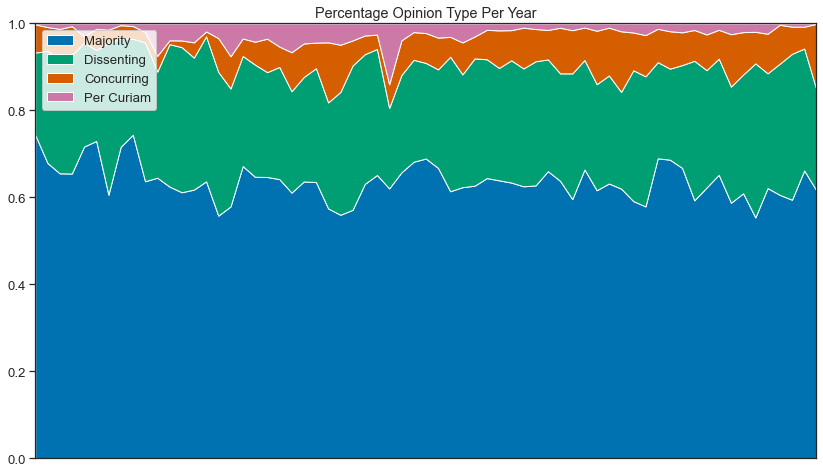

In [37]:
sns.set_palette(sns.color_palette("colorblind"))
colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]} 

    
plt.figure(figsize=(14,8))
plt.stackplot(range(0,65),  
              data_perc[0],  
              data_perc[1],  
              data_perc[2], 
              data_perc[3], 
              labels=['Majority','Dissenting','Concurring', 'Per Curiam'], 
              colors=colorblind,
             )
plt.xticks(np.arange(1945, 2020, 5))
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Percentage Opinion Type Per Year')
plt.savefig(output_path + '/count_over_time')
plt.show()

In [38]:
monologic_df = df[df["prob_1"] > .90]
non_monologic_df = df[df["prob_0"] > .90]

In [39]:
def combine_text(df):
    text_df = df.groupby('opinion_num', as_index = False).agg({'text': ' '.join})
    metadata = df[["opinion_num","category", "author", "case", "year", "monologic_prediction"]].copy()
    metadata = metadata.drop_duplicates()
    full_df = pd.merge(metadata, text_df, on="opinion_num")
    
    return full_df

In [40]:
monologic_text = combine_text(monologic_df)
non_monologic_text = combine_text(non_monologic_df)

In [41]:
non_monologic_text.shape

(16585, 7)

In [42]:
non_monologic_text.head(5)

,opinion_num,category,author,case,year,monologic_prediction,text
0,0,Majority,Justice Roberts,McCutcheon v. Federal Election Comm'n,2014,0,"Citizens can exercise that right in a variety of ways: They can run for office themselves, vote, urge others to vote for a particular candidate, volunteer to work on a campaign, and contribute to ..."
1,1,Concurring,Justice Thomas,McCutcheon v. Federal Election Comm'n,2014,0,"See Randall v. Sorrell, 548 U.S. 230, 265–267 (2006) (THOMAS, J., concurring in judgment); Federal Election Comm’n v. Beaumont, 539 U.S. 146, 164–165 (2003) (THOMAS, J., dissenting); Federal Elect..."
2,2,Dissenting,Justice Breyer,McCutcheon v. Federal Election Comm'n,2014,0,"Id., at 38; accord, McConnell v. Federal Election Comm’n, 540 U.S. 93, 138, n. 40, 152–153, n. 48 (2003) (citing with approval Buckley’s aggregate limits holding). The Buckley Court focused upon t..."
3,3,Per Curiam,per_curiam,Wells v. Reynolds,1965,0,"The judgment is affirmed. MR. JUSTICE DOUGLAS, MR. JUSTICE BRENNAN and MR. JUSTICE FORTAS dissent"
4,4,Per Curiam,per_curiam,Niukkanen v. McAlexander,1960,0,"The petitioner sought relief from an order directing his deportation on the ground that as an alien he had become, after entering the United States, a member of the Communist Party within the mean..."


In [43]:
# Combine (for now)
frames = [monologic_text, non_monologic_text]
df_final = pd.concat(frames, ignore_index = True)

In [44]:
df_final.shape

(31911, 7)

# Monologic Voice By Author
Group by author, then category, and find mean of monologic prediction


In [286]:
# drop error names
per_curiam = ["per_curiam", "Justice Vinson"]

In [287]:
df_filtered = df[~df['author'].isin(per_curiam)]
author_mean = df_filtered.groupby(["author"])["monologic_prediction"].mean()
author_mean = pd.DataFrame(author_mean)

In [289]:
grouped = df_filtered.groupby(["author", "category"])["monologic_prediction"].mean()
grouped_df = pd.DataFrame(grouped)
grouped_df = grouped_df.reset_index(level=['category'])

In [291]:
# Pivot
author_by_category = pd.pivot_table(data=grouped_df,index=['author'], columns = ["category"], values = ["monologic_prediction"])

In [293]:
new_grouped_df =  author_by_category.monologic_prediction.copy(["Majority", "Dissenting", "Concurring"])

In [295]:
# Merge on average to third side
author_overall_category_mean = author_by_category.merge(author_mean, left_index=True, right_index=True, how='inner')

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [297]:
author_overall_category_mean = author_overall_category_mean.reset_index()
# remove "Justice "

In [298]:
author_overall_category_mean.author.replace("Justice ",'',regex=True, inplace = True)

In [299]:
author_overall_category_mean = author_overall_category_mean.set_index("author")

In [300]:
author_overall_category_mean = author_overall_category_mean.sort_values(by=['monologic_prediction'], ascending=False)

In [331]:
def plot_heatmap_by_category(df):
    sns.set(style='ticks', font_scale=2)
    plt.subplots(figsize=(20,20)) 
    mask = df.isnull()
    column_labels = ["Concurring", "Dissenting", "Majority", "Overall"]
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True, reverse=True)
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                xticklabels=column_labels,
                cmap = cmap
                #cmap = "Blues"
               )
    graph.set_facecolor('lightgrey')
    #plt.xlabel('Category')
    plt.ylabel(' ')
    #plt.title("Percentage Monologic Voice by Category")
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/by_justice')
    plt.show()

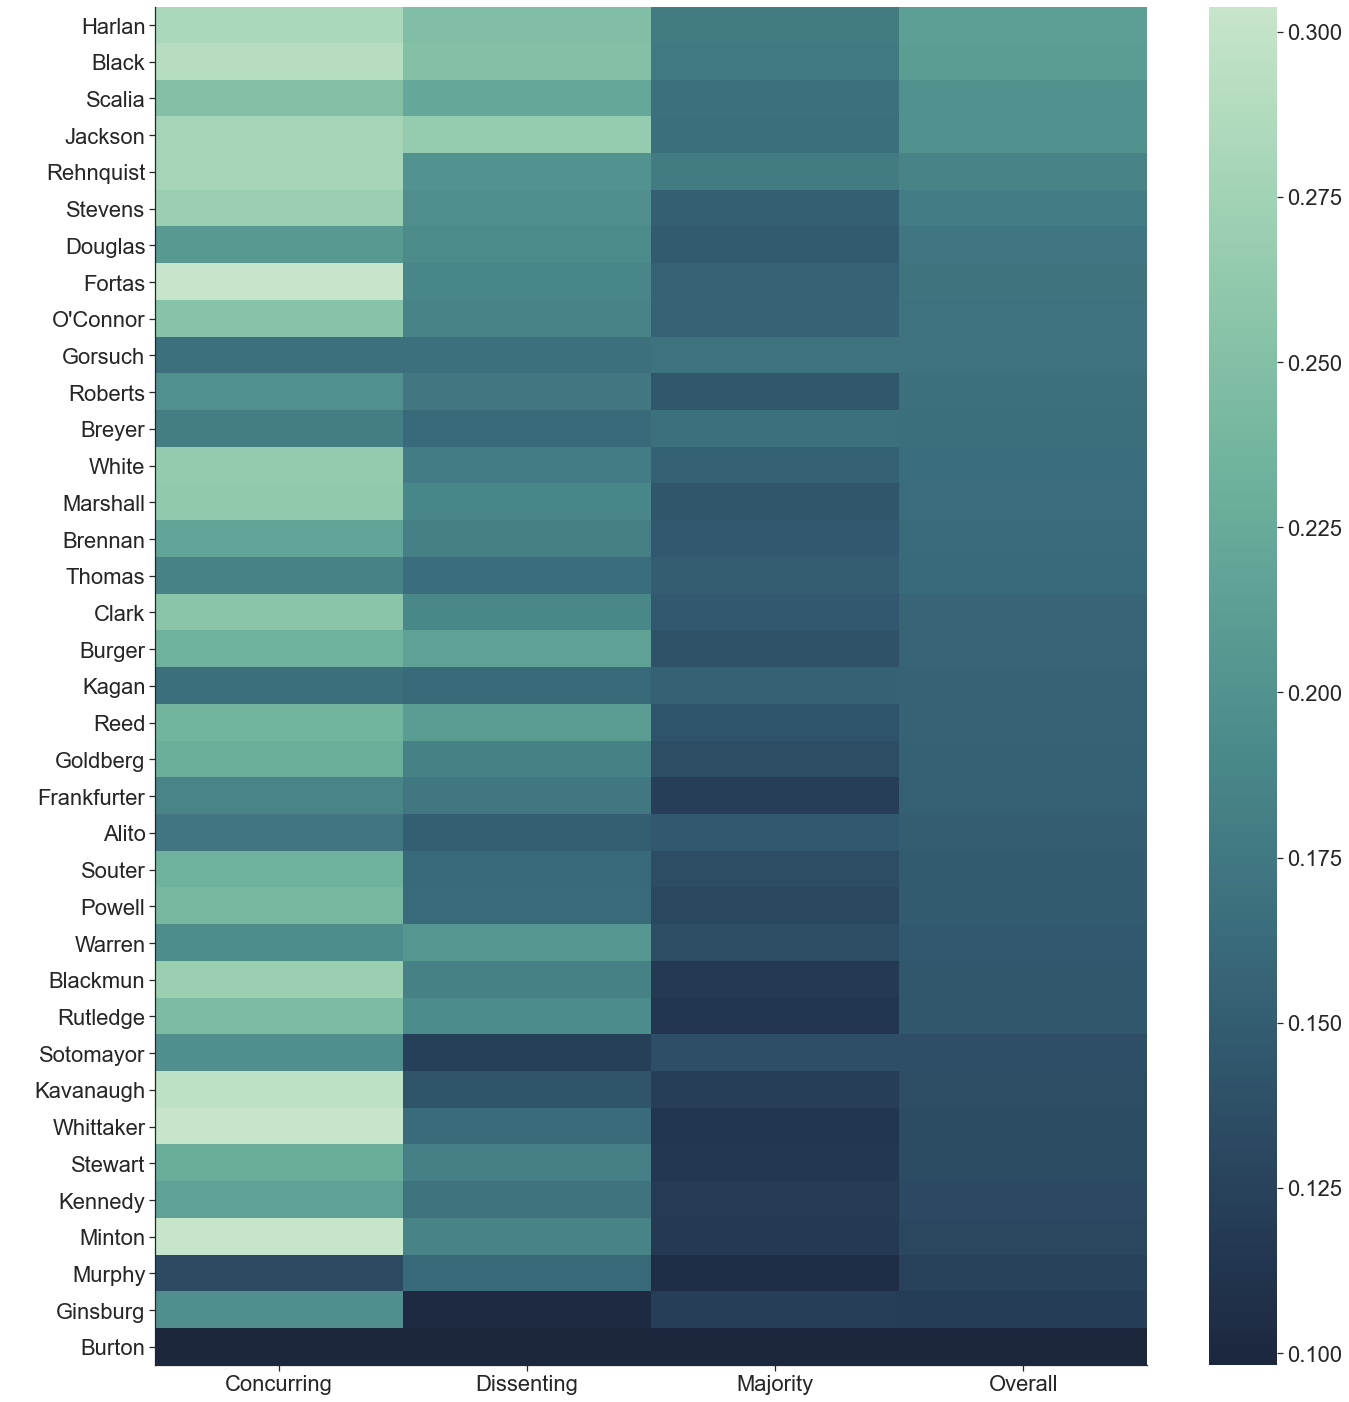

In [332]:
plot_heatmap_by_category(author_overall_category_mean)

Style brings together people who wouldn't normally be in the same group. 


> "Judge **Richard A. Posner**, who was a law clerk at the Court during the latter part of Douglas's tenure, characterized him as "a bored, distracted, uncollegial, irresponsible" Supreme Court justice, as well as "rude, ice-cold, hot-tempered, ungrateful, foul-mouthed, self-absorbed" and so abusive in "treatment of his staff to the point where his law clerks—whom he described as 'the lowest form of human life'—took to calling him "shithead" behind his back." Posner asserts also that "Douglas's judicial oeuvre is slipshod and slapdash," but Douglas's "intelligence, his energy, his academic and government experience, his flair for writing, the leadership skills that he had displayed at the SEC, and his ability to charm when he bothered to try" could have let him "become the greatest justice in history."

# Fightin words

In [59]:
from collections import Counter
import regex
import numpy as np
from matplotlib import pyplot

In [60]:
def plot_words(y_value):
    y_std = y_value.std()
    pyplot.figure(figsize=(18,18))
    pyplot.scatter(log_type_frequencies, y_value, alpha=0.3)
    for i in range(len(vocabulary)):
        if np.abs(y_value[i]) > 5 * y_std:
            pyplot.text(log_type_frequencies[i], y_value[i], vocabulary[i])
    pyplot.xlim([5, 14])
    pyplot.show()
    plt.savefig(output_path + '/fightin_words')

In [61]:
# Monologic to non-monologic
monologic_list = monologic_text.text.tolist()
non_monologic_list = non_monologic_text.text.tolist()

In [62]:
dissenting_monologic = monologic_text[monologic_text["category"] == "Dissenting"]
concurring_monologic = monologic_text[monologic_text["category"] == "Concurring"]
majority_monologic = monologic_text[monologic_text["category"] == "Majority"]
per_curiam_monologic = monologic_text[monologic_text["category"] == "Per Curiam"]

dissenting_text = dissenting_monologic.text.tolist()
concurring_text = concurring_monologic.text.tolist()
dissenting_concurring_text = dissenting_text + concurring_text

majority_text = majority_monologic.text.tolist()
per_curiam_text = per_curiam_monologic.text.tolist()
majority_per_curiam_text = majority_text + per_curiam_text

In [206]:
list1 = monologic_list
list2 = non_monologic_list

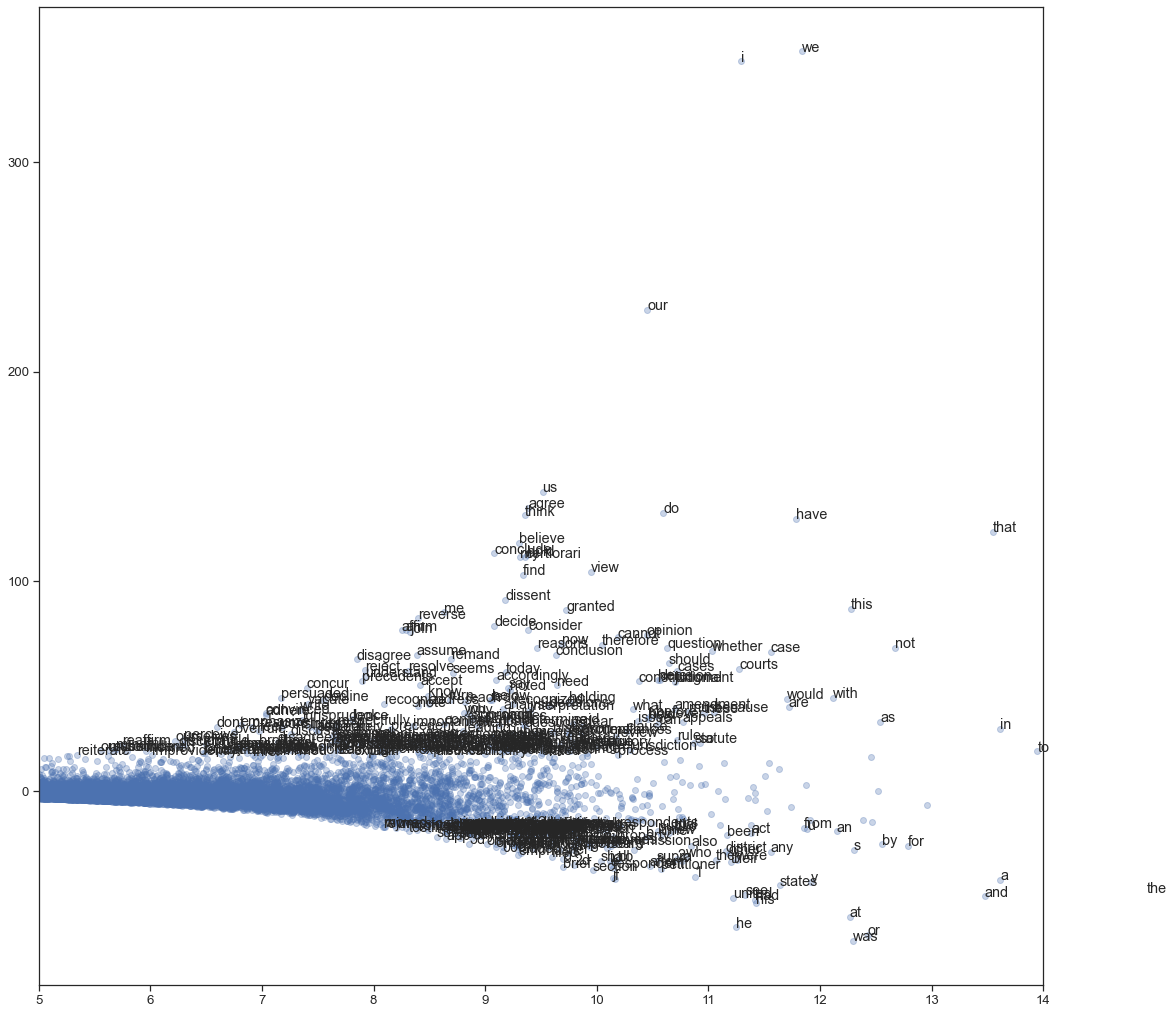

<Figure size 432x288 with 0 Axes>

In [208]:
word_pattern = regex.compile(r"\w+")
counter_1 = Counter()
counter_2 = Counter()


for line in list1:
    tokens = word_pattern.findall(line.lower())
    counter_1.update(tokens)

for line in list2:
    tokens = word_pattern.findall(line.lower())
    counter_2.update(tokens)

all_counter = counter_1 + counter_2
vocabulary = list(all_counter.keys())

word_counts = np.zeros((len(vocabulary), 2))

for row, word in enumerate(vocabulary):
    word_counts[row,0] = counter_1[word]
    word_counts[row,1] = counter_2[word]

np.set_printoptions(suppress=True)

type_frequencies = word_counts.sum(axis=1)
log_type_frequencies = np.log(type_frequencies)

smoothed_word_counts = word_counts + 1.0
smoothed_author_sums = smoothed_word_counts.sum(axis=0)
smoothed_word_odds = smoothed_word_counts / (smoothed_author_sums[np.newaxis,:] - smoothed_word_counts)

log_odds_difference = np.log(smoothed_word_odds[:,0] / smoothed_word_odds[:,1])
log_odds_variances = 1.0 / smoothed_word_counts[:,0] + 1.0 / smoothed_word_counts[:,1]

plot_words(log_odds_difference / np.sqrt(log_odds_variances))
plt.show()

In [209]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer as CV
import string
exclude = set(string.punctuation)

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''  
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = None):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.
    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        cv = CV(decode_error = 'ignore', min_df = 10, max_df = .5, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in sorted_indices:
        return_list.append((index_to_term[i], z_scores[i]))
    return return_list

In [210]:
output = bayes_compare_language(list1, list2)

Vocab size is 15000
Comparing language...


In [211]:
output[:10]

[('he', -60.56896664574997),
 ('his', -47.8386978969661),
 ('united', -45.93732469118413),
 ('see', -44.07336906222047),
 ('section', -35.913656416750705),
 ('brief', -34.90761197856209),
 ('respondent', -34.15453115239807),
 ('petitioner', -33.59747515780744),
 ('after', -32.39044897228755),
 ('id', -30.78676461865894)]

In [212]:
monologic_words = pd.DataFrame(output[-40:])

In [213]:
monologic_words = monologic_words.sort_values(by=[1], ascending=False)

In [214]:
monologic_words.to_csv("Results/majority_list.csv")

In [215]:
non_monologic_words = pd.DataFrame(output[:100])

In [217]:
# remove citation words
# united, see, section, id, supra, co, f2d
citations = ["united", "see", "section", "id", "supra", "co", "f2d", "brief", "2d", "f3d", "ed", "ante"]
non_monologic_words = non_monologic_words[~non_monologic_words[0].isin(citations)]

In [218]:
non_monologic_words = non_monologic_words.head(40)

In [220]:
non_monologic_words.to_csv("Results/individual_list.csv")

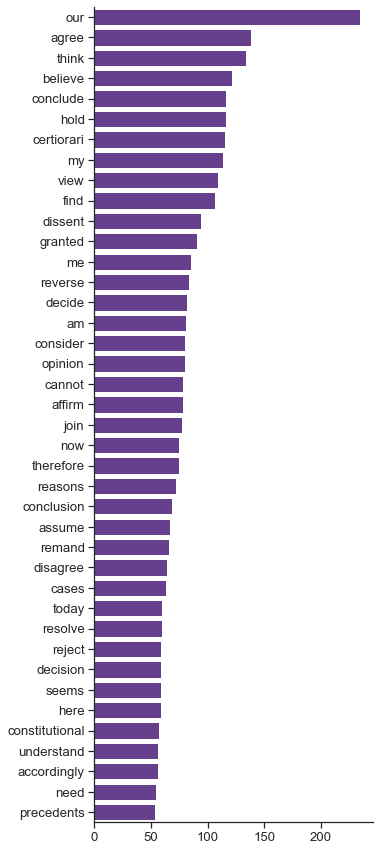

In [222]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(5,15))
#sns.barplot(x=1, y=0, data=monologic_words, color="tab:purple")
sns.barplot(x=1, y=0, data=monologic_words, color="rebeccapurple")
#plt.xticks([])

plt.xlabel('')
plt.ylabel('')
#plt.title("Monologic Voice Over Opinion Time")
#plt.tight_layout()
sns.despine()
plt.savefig(output_path + '/monol_distinct')
plt.show()

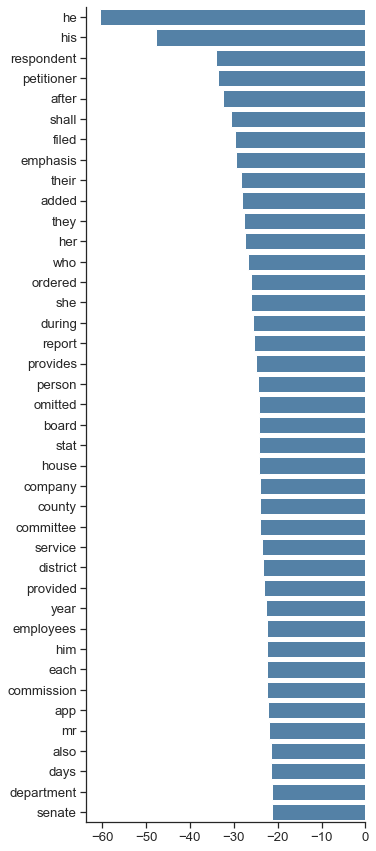

In [223]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(5,15))
sns.barplot(x=1, y=0, data=non_monologic_words, color="steelblue")
#plt.xticks([])

plt.xlabel('')
plt.ylabel('')
#plt.title("Monologic Voice Over Opinion Time")
#plt.tight_layout()
sns.despine()
plt.savefig(output_path + '/non_monol_distinct')
plt.show()

## Comparing Monologic Prediction w/ Personal Pronouns

In [81]:
# Compare sentences with "we" "I" or "us" in sentence to bert classifications
# Create new pandas column that marks whether or not the above words appear in the sentence
def find_personal_pronouns(string):
    regex = re.compile(r'\bWE\b | \bI\b | \bUS\b | \bOUR\b', flags=re.I | re.X)
    response = regex.findall(string)
    pronoun_presence = bool(response)
    
    # could also return "response" if actually want pronoun
    return pronoun_presence

When looking at mismatched pronounds/predictions, I noticed that the mismatch often had words "Court" or "plurality" in them. However, once I added that to the above, accuracy based off of manual pronouns went down (because there are many cases where either word is used in a non-monologic way--they are less predictive).

In [82]:
df["personal_pronoun"] = df["text"].apply(find_personal_pronouns)

In [83]:
df.loc[((df['personal_pronoun'] == True) & (df['monologic_prediction'] == 1)), 'monologic_pronoun_align'] = "True"
df.loc[((df['personal_pronoun'] == False) & (df['monologic_prediction'] == 0)), 'monologic_pronoun_align'] = "True"

df.loc[((df['personal_pronoun'] == True) & (df['monologic_prediction'] == 0)), 'monologic_pronoun_align'] = "False"
df.loc[((df['personal_pronoun'] == False) & (df['monologic_prediction'] == 1)), 'monologic_pronoun_align'] = "False"

In [84]:
df[df["monologic_pronoun_align"]=="False"].sample(20)

,opinion_num,category,author,case,year,text,sent_index,length,sent_location,percent_letter,predictions,prob_0,prob_1,monologic_prediction,sentence_length,chief_justice,bins,personal_pronoun,monologic_pronoun_align
76254,760,Majority,Justice Ginsburg,"EPA v. EME Homer City Generation, L. P.",2014,"“The wind bloweth where it listeth, and thou hearest the sound thereof, but canst not tell whence it cometh, and whither it goeth.” The Holy Bible, John 3:8 (King James Version).",29,491,0.059063,75.842697,"[0.23796714842319489, 0.7620328068733215]",0.237967,0.762033,1,178,Roberts,1,False,False
1527263,14354,Majority,Justice Warren,Allen v. State Bd. of Elections,1968,"Appellees argue that this sentence refers only to the action specifically mentioned in the first sentence of § 5 (i. e., declaratory judgment suits brought by the State) and does not apply to suit...",137,425,0.322353,80.000000,"[0.9975442290306091, 0.002455711830407381]",0.997544,0.002456,0,230,Warren,6,True,False
1711211,16193,Majority,Justice Scalia,Norfolk Shipbuilding & Drydock Corp. v. Garris,2001,"I According to the complaint that respondent filed in the United States District Court for the Eastern District of Virginia, her son, Christopher Garris, sustained injuries on April 8, 1997, that ...",1,116,0.008621,79.295154,"[0.8042424321174622, 0.19575756788253784]",0.804242,0.195758,0,227,Rehnquist,0,True,False
1251781,11726,Dissenting,Justice Scalia,Almendarez-Torres v. United States,1998,"Whatever else one may say about todays opinion, there is no doubt that it has brought to this area of the law more confusion than clarification.",164,264,0.621212,81.250000,"[0.024643750861287117, 0.9753562211990356]",0.024644,0.975356,1,144,Rehnquist,12,False,False
868180,8124,Majority,Justice Breyer,"Denver Area Ed. Telecommunications Consortium, Inc. v. FCC",1996,I Cable operators typically own a physical cable network used to convey programming over several dozen cable channels into subscribers houses.,11,427,0.025761,85.211268,"[0.9959512948989868, 0.004048723261803389]",0.995951,0.004049,0,142,Rehnquist,0,True,False
118354,1159,Dissenting,Justice Stevens,McMillan v. Pennsylvania,1986,"In reasoning to this conclusion the Court reviewed the heritage of the rule that Justice Frankfurter characterized as ""basic in our law and rightly one of the boasts of *97 a free society,""1 and ,...",18,80,0.225000,80.256410,"[0.552994430065155, 0.44700556993484497]",0.552994,0.447006,0,390,Burger,4,True,False
328503,3200,Majority,Justice Brennan,Baker v. Carr,1962,"I, § 4, that ""The Times, Places and Manner of holding Elections for .",367,526,0.697719,71.014493,"[0.9963619112968445, 0.003638089634478092]",0.996362,0.003638,0,69,Warren,13,True,False
54523,555,Majority,Justice Breyer,Barber v. Thomas,2010,"In other words, petitioners argue that the BOP should award good time credit not only for the days a prisoner spends in prison and behaves appropriately, but also for days that he will not spend i...",88,232,0.379310,79.098361,"[0.9914159178733826, 0.008584069088101387]",0.991416,0.008584,0,244,Roberts,7,True,False
1769575,16770,Dissenting,Justice Marshall,Fiallo v. Bell,1977,"Matter of Stultz, 15 I.",127,172,0.738372,65.217391,"[0.9913079142570496, 0.008692117407917976]",0.991308,0.008692,0,23,Burger,14,True,False
873909,8177,Majority,Justice Souter,Christopher v. Harbury,2002,"Nor did the court hold that qualified immunity would bar suit because, in its words, ""we think it should be obvious to public officials that they may not affirmatively mislead citizens for the pur...",74,136,0.544118,81.856540,"[0.6344181299209595, 0.3655818700790405]",0.634418,0.365582,0,237,Rehnquist,10,True,False


In [85]:
text_counter = Counter()
text_counter.update(df["monologic_pronoun_align"])
text_counter = dict(text_counter)

In [86]:
counted_matches = pd.DataFrame.from_dict(text_counter, orient='index').reset_index()
counted_matches

,index,0
0,True,1468218
1,False,74040


In [87]:
all_match = counted_matches.iloc[0][0]
all_mismatch = counted_matches.iloc[1][0]
all_match / (all_match + all_mismatch)*100

95.19924681862568

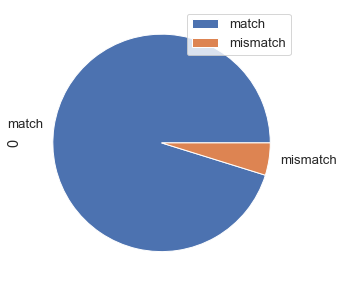

In [88]:
labels = ["match", "mismatch"]
counted_matches.plot.pie(y=0, labels = labels, figsize=(5, 5));

In [89]:
mono_df = df[df["monologic_prediction"] == 1]

In [90]:
mono_counter = Counter()
mono_counter.update(mono_df["monologic_pronoun_align"])
mono_counter = dict(mono_counter)

In [91]:
mono_matches = pd.DataFrame.from_dict(mono_counter, orient='index').reset_index()
mono_matches

,index,0
0,True,216001
1,False,33168


In [92]:
mono_match = mono_matches.iloc[0][0]
mono_mismatch = mono_matches.iloc[1][0]
mono_match / (mono_match + mono_mismatch)*100

86.6885527493388

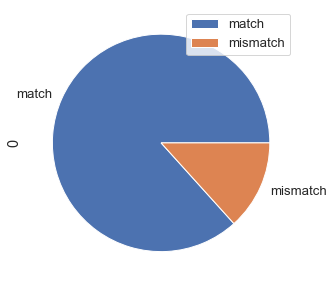

In [93]:
labels = ["match", "mismatch"]
mono_matches.plot.pie(y=0, labels = labels, figsize=(5, 5));

In [94]:
non_mono_df = df[df["monologic_prediction"] == 0]
non_mono_counter = Counter()
non_mono_counter.update(non_mono_df["monologic_pronoun_align"])
non_mono_counter = dict(non_mono_counter)
non_mono_matches = pd.DataFrame.from_dict(non_mono_counter, orient='index').reset_index()
non_mono_matches

,index,0
0,True,1252217
1,False,40872


In [95]:
non_mono_match = non_mono_matches.iloc[0][0]
non_mono_mismatch = non_mono_matches.iloc[1][0]

non_mono_match / (non_mono_match + non_mono_mismatch)*100

96.83919668329094

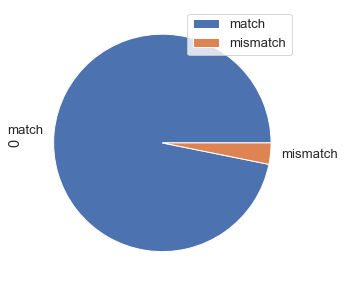

In [96]:
labels = ["match", "mismatch"]
non_mono_matches.plot.pie(y=0, labels = labels, figsize=(5, 5));

# Analysis of Mismatch Text

In [97]:
pronoun_df = df[df["personal_pronoun"] == True]

In [ ]:
mismatch_pronoun = pronoun_df[pronoun_df["monologic_pronoun_align"] == "False"]

In [99]:
mismatch_pronoun.sample(5)

,opinion_num,category,author,case,year,text,sent_index,length,sent_location,percent_letter,predictions,prob_0,prob_1,monologic_prediction,sentence_length,chief_justice,bins,personal_pronoun,monologic_pronoun_align
1317532,12353,Majority,Justice Stevens,"Pharmaceutical Research and Manufacturers of America v. Walsh, Acting Commissioner, Maine Department of Human Services",2003,"Its brief cautioned against the adoption of a rule prohibiting prior authorization programs whenever they operate in part to benefit a non-Medicaid population, and suggested that a program tailore...",90,258,0.348837,83.253589,"[0.9382842183113098, 0.06171581149101257]",0.938284,0.061716,0,627,Rehnquist,6,True,False
1424552,13352,Majority,Justice Scalia,Atlantic Mut. Ins. Co. v. Commissioner,1998,"There was certainly no need for that deduction to be microscopically fair, and the interpretation adopted by the Treasury Regulation seems to us a reasonable accommodation,and one that the statute...",90,93,0.967742,82.565789,"[0.7689269185066223, 0.23107309639453888]",0.768927,0.231073,0,304,Rehnquist,19,True,False
982593,9235,Concurring,Justice Blackmun,"Fort Wayne Books, Inc. v. Indiana",1989,"Paris Adult Theatre I v. Slaton, 413 U.S. 49, 104-105 (1973) (BRENNAN, J., dissenting) (outlining obscenity laws history).",91,136,0.669118,60.655738,"[0.9963739514350891, 0.0036260553169995546]",0.996374,0.003626,0,122,Rehnquist,13,True,False
470508,4477,Dissenting,Justice Ginsburg,Agostini v. Felton,1997,"The Court says that the District Court was right to ""entertain"" the Rule 60(b) motion and also right to reject it, *259 leaving to this Court the option of overruling our previously binding decision.",65,94,0.691489,77.386935,"[0.9886218905448914, 0.011378164403140545]",0.988622,0.011378,0,199,Rehnquist,13,True,False
648360,6135,Majority,Justice Rehnquist,Washington v. Glucksberg,1997,"The risk of harm is greatest for the many individuals in our society whose autonomy and well-being are already compromised by poverty, lack of access to good medical care, advanced age, or members...",280,320,0.875000,81.385281,"[0.6006031632423401, 0.3993968367576599]",0.600603,0.399397,0,231,Rehnquist,17,True,False


In [100]:
no_pronoun_df = df[df["personal_pronoun"] == False]

In [101]:
mismatch_without_pronoun = no_pronoun_df[no_pronoun_df["monologic_pronoun_align"] == "False"]

In [102]:
mismatch_without_pronoun.sample(5)

,opinion_num,category,author,case,year,text,sent_index,length,sent_location,percent_letter,predictions,prob_0,prob_1,monologic_prediction,sentence_length,chief_justice,bins,personal_pronoun,monologic_pronoun_align
1343219,12604,Dissenting,Justice Scalia,Atkins v. Virginia,2002,There is something to be said for popular abolition of the death penalty; there is nothing to be said for its incremental abolition by this Court.,170,186,0.913978,81.506849,"[0.44309303164482117, 0.5569069385528564]",0.443093,0.556907,1,146,Rehnquist,18,False,False
1343152,12604,Dissenting,Justice Scalia,Atkins v. Virginia,2002,"For that reason, even if there were uniform national sentiment in favor of executing the retarded in appropriate cases, one would still expect execution of the mentally retarded to be ""uncommon.""",103,186,0.553763,82.051282,"[0.2732063829898834, 0.726793646812439]",0.273206,0.726794,1,195,Rehnquist,11,False,False
892447,8356,Dissenting,Justice Douglas,Newspaper Pub. Assn. v. Labor Board,1953,But the situation in this case is to me quite different.,15,27,0.555556,80.357143,"[0.008071248419582844, 0.9919288158416748]",0.008071,0.991929,1,56,Vinson,11,False,False
661793,6276,Dissenting,Justice Warren,Wyatt v. United States,1960,"Moreover, the Court rejects the notion that the latter may be barred from asserting the privilege simply because, in a given case, it may be improper for the former to invoke it.",10,50,0.200000,80.337079,"[0.2090281993150711, 0.7909718155860901]",0.209028,0.790972,1,178,Warren,4,False,False
395570,3800,Dissenting,Justice Marshall,Chemical Manufacturers Assn. v. NRDC,1985,"As this Court has repeatedly stated: ""The interpretation put on the statute by the agency charged with administering it is entitled to deference, but the courts are the final authorities on issues...",190,356,0.533708,82.959641,"[0.19809381663799286, 0.801906168460846]",0.198094,0.801906,1,223,Burger,10,False,False


# Most monologic opinions

In [103]:
df_long_opinion = df[df["length"] >20]

In [104]:
opinion_mean = df_long_opinion.groupby(["opinion_num", "case", "category", "year", "author", "length"])["monologic_prediction"].mean()

In [105]:
opinion_mean_df = pd.DataFrame(opinion_mean)

In [106]:
pd.set_option('display.max_rows', 500)

In [107]:
opinion_mean_df.to_csv("opinion_monologic_rating.csv")

In [108]:
opinion_mean_df.sort_values(by=['monologic_prediction'], ascending=False).head(50)

,,,,,,monologic_prediction
opinion_num,case,category,year,author,length,
3489,Mishkin v. New York,Dissenting,1966,Justice Black,21,0.809524
12833,John R. Sand & Gravel Co. v. United States,Dissenting,2008,Justice Stevens,30,0.739130
10821,Jenkins v. Delaware,Dissenting,1969,Justice Harlan,25,0.727273
7182,Nixon v. Fitzgerald,Dissenting,1982,Justice Blackmun,21,0.722222
1422,Bloom v. Illinois,Concurring,1968,Justice Fortas,33,0.718750
10790,Montana v. Hall,Dissenting,1987,Justice Marshall,44,0.704545
5904,Georgia v. McCollum,Concurring,1992,Justice Rehnquist,47,0.682927
16449,Donovan v. Dewey,Concurring,1981,Justice Stevens,26,0.681818
5187,Herring v. United States,Dissenting,2009,Justice Breyer,21,0.666667


Rutledge, Concurring, *Commissioner v. Tower*:
>"I agree with the result and with the Court's view that the evidence was amply sufficient to sustain the Tax Court's findings and conclusions in this case and in Lusthaus v. Commissioner, post, p. 327 U. S. 293. Candor forces me to add, however, that, in my judgment, the decisions' effect is to rule that, in situations of this character, the formation of a limited partnership under state law between husband and wife, with the latter as the limited partner, following immediately upon the husband's donation to the wife of a share in the assets of the business previously and afterwards conducted by him and conditioned upon her leaving the assets in the business, as a matter of federal tax law does not accomplish the formation of a partnership sufficient to relieve the husband of tax liability for the income derived after the transfer from use in the business of the share thus donated to the wife. In other words, I think that, as a matter of law, the taxpayers in these cases were liable for the taxes assessed against them, including the deficiency assessments, and therefore, in my opinion, the Tax Court is not free in these or substantially similar circumstances to draw either the contrary conclusion or opposing ones. While it is not strictly necessary to express this opinion in these cases in view of the Tax Court's consistent conclusions of liability, it is inconceivable to me that the two cases, consistently with the federal tax law, could be decided the other way, or with different outcomes on the facts presented. Being of this opinion, I consider the failure to state it could only tend to perpetuate a source of possible confusion for the future." 

Brennan, Concurring, *Maynard v. Cartwright*:
>"I join the Court's opinion except insofar as the judgment, which is without prejudice to further sentencing proceedings, does not expressly preclude the reimposition of the death penalty. Adhering to my view that the death penalty is in all circumstances cruel and unusual punishment prohibited by the Eighth and Fourteenth Amendments, Gregg v. Georgia, 428 U. S. 153, 428 U. S. 227, 428 U. S. 231 (1976), I would direct that the resentencing proceedings be circumscribed such that the State may not reimpose the death sentence." 

Marshall, Dissenting, *Harris v. Rivera*:
> "I write separately to underscore my disapproval of what I perceive to be a growing and inexplicable readiness on the part of this Court to "dispose of" cases summarily. Perhaps this trend is due to what is often lamented as our "increasing caseload." Whatever the reason for this trend, I believe that it can only detract from this Court's decisions in deserving cases by consuming time and energy better spent elsewhere. 

> Moreover, by deciding cases summarily, without benefit of oral argument and full briefing, and often with only limited access to, and review of, the record, this Court runs a great risk of rendering erroneous or ill-advised decisions that may confuse the lower courts: there is no reason to believe that this Court is immune from making mistakes, particularly under these kinds of circumstances. As Justice Jackson so aptly put it, although in a somewhat different context: "We are not final because we are infallible, but we are infallible only because we are final." Brown v. Allen, 344 U. S. 443, 344 U. S. 540 (1953) (concurring in result). I believe that this Court should reserve its final imprimatur for those cases to which we give plenary review, after full briefing and argument.

> This is not to say that I believe that summary disposition is never appropriate. In my view, however, this Court should utilize this practice with more caution than has been true in the recent past." 

Breyer, Concurring, *Greenlaw v. United States*
>"I agree with Justice Alito that the cross-appeal requirement is simply a rule of practice for appellate courts, rather than a limitation on their power, and I therefore join Parts I–III of his opinion. Moreover, as a general matter, I would leave application of the rule to the courts of appeals, with our power to review their discretion “seldom to be called into action.” Universal Camera Corp. v. NLRB, 340 U. S. 474, 490 (1951). But since this case is now before us, I would consider whether the Court of Appeals here acted properly. Primarily for the reasons stated by the majority in footnote 9 of its opinion, I believe that the court abused its discretion in sU. S.onte increasing petitioner’s sentence. Our precedent precludes the creation of an exception to the cross-appeal requirement based solely on the obviousness of the lower court’s error. See, e.g., Chittenden v. Brewster, 2 Wall. 191, 195–196 (1865). And I cannot see how the interests of justice are significantly disserved by permitting petitioner’s release from prison at roughly age 62, after almost 37 years behind bars, as opposed to age 77."


**LONGER**
Black, Dissenting, *Mishkin v. New York*
>"The Court here affirms convictions and prison sentences aggregating three years plus fines totaling /12,000 imposed on appellant Mishkin based on state charges that he hired others to prepare and publish obscene books and that Mishkin himself possessed such books. This Court has held in many cases that the Fourteenth Amendment makes the First applicable to the States. See, for illustration, cases collected in my concurring opinion in Speiser v. Randall, 357 U. S. 513, 357 U. S. 530. Consequently, upon the same grounds that I dissented from a five-year federal sentence imposed upon Ginzburg in 383 U. S. 383 U.S. 476 for sending "obscene" printed matter through the United States mails, I dissent from affirmance of this three-year state sentence imposed on Mishkin. Neither in this case nor in Ginzburg have I read the alleged obscene matter. This is because I believe, for reasons stated in my dissent in Ginzburg and in many other prior cases, that this Court is without constitutional power to censor speech or press regardless of the particular subject discussed. I think the federal judiciary, because it is appointed for life, is the most appropriate tribunal that could be selected to interpret the Constitution, and thereby mark the boundaries of what government agencies can and cannot do. But because of life tenure, as well as other reasons, the federal judiciary is the least appropriate branch of government to take over censorship responsibilities by deciding what pictures and writings people throughout the land can be permitted to see and read. When this Court makes particularized rules on what people can see and read, it determines which policies are reasonable and right, thereby performing the classical function of legislative bodies directly responsible to the people. Accordingly, I wish once more to express my objections to saddling this Court with the irksome and inevitably unpopular and unwholesome task of finally deciding by a case-by-case, sight-by-sight personal judgment of the members of this Court what pornography (whatever that means) is too hard core for peopleto see or read. If censorship of views about sex or any other subject is constitutional, then I am reluctantly compelled to say that I believe the tedious, time-consuming and unwelcome responsibility for finally deciding what particular discussions or opinions must be suppressed in this country should, for the good of this Court and of the Nation, be vested in some governmental institution or institutions other than this Court.

>I would reverse these convictions. The three-year sentence imposed on Mishkin and the five-year sentence imposed on Ginzburg for expressing views about sex are minor in comparison with those more lengthy sentences that are inexorably bound to follow in state and federal courts as pressures and prejudices increase and grow more powerful, which of course they will. Nor is it a sufficient answer to these assuredly ever-increasing punishments to rely on this Court's power to strike down "cruel and unusual punishments" under the Eighth Amendment. Distorting or stretching that Amendment by reading it as granting unreviewable power to this Court to perform the legislative function of fixing punishments for all state and national offenses offers a sadly inadequate solution to the multitudinous problems generated by what I consider to be the un-American policy of censoring the thoughts and opinions of people. The only practical answer to these concededly almost unanswerable problems is, I think, for this Court to decline to act as a national board of censors over speech and press, but instead to stick to its clearly authorized constitutional duty to adjudicate cases over things and conduct. Halfway censorship methods, no matter how laudably motivated, cannot, in my judgment, protect our cherished First Amendment freedoms from the destructive aggressions of both state and national government. I would reverse this case and announce that the First and Fourteenth Amendments, taken together, command that neither Congress nor the States shall pass laws which in any manner abridge freedom of speech and press -- whatever the subjects discussed. I think the Founders of our Nation, in adopting the First Amendment, meant precisely that the Federal Government should pass "no law" regulating speech and press, but should confine its legislation to the regulation of conduct. So too, that policy of the First Amendment, made applicable to the States by the Fourteenth, leaves the States vast power to regulate conduct, but no power at all, in my judgment, to make the expression of views a crime.

**What cases (w/ all opinions) have the highest monologic percentage? When does everybody talk about themselves/the court?**

Maybe also control for # of opinions? BUT the first hit actually has two opinions--they're just short. 

In [109]:
case_mean = df_long_opinion.groupby(["case", "year"])["monologic_prediction"].mean()

In [110]:
case_mean_df = pd.DataFrame(case_mean)

In [111]:
case_mean_df.sort_values(by=['monologic_prediction'], ascending=False).head(50)

,,monologic_prediction
case,year,
Leyra v. Denno,1954,0.567925
Carter v. West Feliciana Parish School Bd.,1970,0.560000
Zatko v. California,1991,0.555556
Dixon v. Duffy,1952,0.549020
Sacher v. United States,1952,0.543876
"Whitaker v. Superior Court of Cal., San Francisco Cty.",1995,0.500000
Idaho Dept. of Employment v. Smith,1977,0.500000
Martin v. District of Columbia Court of Appeals,1992,0.482759
Maleng v. Cook,1989,0.480000


In [112]:
case_mean_df.to_csv("case_monologic_rating.csv")

## Correlation Between Monologic Voice and Ideology

In [113]:
author_mean.head()

,monologic_prediction
author,
Justice Alito,0.149733
Justice Black,0.210437
Justice Blackmun,0.144263
Justice Brennan,0.162943
Justice Breyer,0.165900


In [114]:
martin_quinn = pd.read_csv("Data/martin_quinn.csv")

In [115]:
martin_quinn

,term,justice,justiceName,post_mn,post_sd,post_med,post_025,post_975
0,1965,97,AFortas,-1.332,0.267,-1.323,-1.894,-0.830
1,1966,97,AFortas,-1.514,0.224,-1.508,-1.975,-1.098
2,1967,97,AFortas,-1.355,0.225,-1.346,-1.824,-0.938
3,1968,97,AFortas,-1.099,0.283,-1.088,-1.694,-0.581
4,1962,96,AJGoldberg,-1.154,0.225,-1.145,-1.608,-0.732
...,...,...,...,...,...,...,...,...
750,1971,81,WODouglas,-7.752,0.972,-7.722,-9.729,-5.967
751,1972,81,WODouglas,-7.782,1.003,-7.757,-9.792,-5.920
752,1973,81,WODouglas,-7.821,1.039,-7.790,-9.879,-5.874
753,1974,81,WODouglas,-7.890,1.072,-7.864,-10.025,-5.878


In [116]:
martin_quinn_mean = pd.DataFrame(martin_quinn.groupby(["justiceName"])["post_mn"].mean())

In [119]:
scd_list_names = list(martin_quinn_mean.index)

In [120]:
# create justice matcher
def match_scd_author(df_col):
    try:
        if df_col == "Justice O'Connor":
            scd_name = "SDOConnor"
        else:
            match = re.search(r'Justice (\S+)', df_col)
            last_name = match.group(1)
            for name in scd_list_names:
                if last_name in name:
                    scd_name = name
    except AttributeError:
        scd_name = "Per Curiam"      
    return scd_name

In [121]:
author_mean = author_mean.reset_index()

In [122]:
author_mean["scd_name"] = author_mean.apply(lambda row: match_scd_author(row["author"]),axis=1)

In [124]:
martin_quinn_mean = martin_quinn_mean.reset_index()

In [125]:
# merge df and martin_quinn_ave
justice_monologic_ideology = author_mean.merge(martin_quinn_mean, left_on = "scd_name", right_on = "justiceName")

In [126]:
monologic_array = justice_monologic_ideology["monologic_prediction"].array
ideology_array = justice_monologic_ideology["post_mn"].array

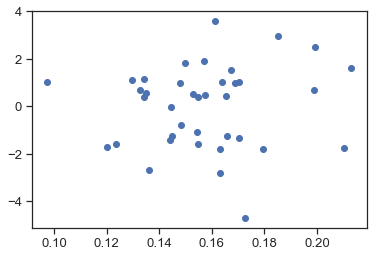

In [127]:
pyplot.scatter(monologic_array, ideology_array);

In [128]:
from scipy.stats import pearsonr

In [129]:
corr, _ = pearsonr(monologic_array, ideology_array)

In [130]:
corr

0.09546386997302425

### By year

In [131]:
author_by_year = df.groupby(['author', 'year', 'chief_justice'], as_index=False)['monologic_prediction'].mean()

In [132]:
author_by_year["scd_name"] = author_by_year.apply(lambda row: match_scd_author(row["author"]),axis=1)

In [134]:
year_monologic_ideology = pd.merge(author_by_year, martin_quinn,  how='left', left_on=['scd_name','year'], right_on = ['justiceName','term'])

In [135]:
index_names = year_monologic_ideology[year_monologic_ideology['author'] == "per_curiam"].index
  
# drop these row indexes
# from dataFrame
year_monologic_ideology.drop(index_names, inplace = True)

In [136]:
year_monologic_ideology = year_monologic_ideology.dropna()

In [137]:
monologic_years_array = year_monologic_ideology["monologic_prediction"].values.reshape(-1, 1)
year_ideology_array = year_monologic_ideology["post_mn"].values.reshape(-1, 1)

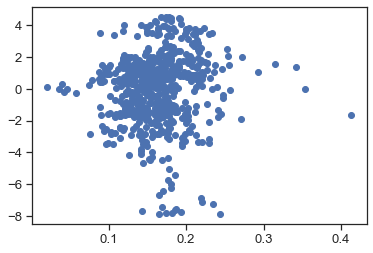

In [138]:
plt.scatter(monologic_years_array, year_ideology_array);

Coefficients: 
 [[3.45301007]]
Mean squared error: 4.33
Coefficient of determination: -28.36


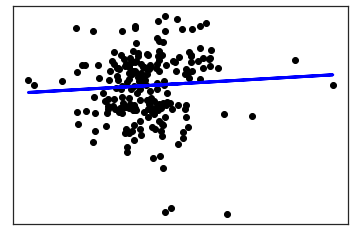

In [139]:
X_train, X_test, y_train, y_test = train_test_split(monologic_years_array, year_ideology_array, test_size=0.33, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
monologic_ideol_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, monologic_ideol_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X_test, monologic_ideol_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, monologic_ideol_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [140]:
corr = pearsonr(year_monologic_ideology["monologic_prediction"].array, year_monologic_ideology["post_mn"].array)

In [141]:
corr

(0.059105526620437124, 0.1346565822849498)

In [142]:
Counter(year_monologic_ideology.chief_justice)

Counter({'Roberts': 117,
         'Vinson': 72,
         'Warren': 144,
         'Burger': 151,
         'Rehnquist': 158})

<Figure size 1440x1440 with 0 Axes>

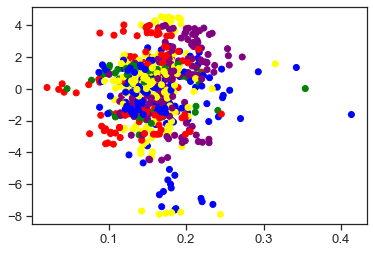

In [143]:
plt.figure(figsize=(20,20))
fig, ax = plt.subplots()


colors = {'Roberts':'red', 'Vinson':'green', 'Warren':'blue', 'Burger':'yellow', 'Rehnquist':'purple'}


ax.scatter(year_monologic_ideology['monologic_prediction'], 
           year_monologic_ideology['post_mn'], 
           c=year_monologic_ideology["chief_justice"].map(colors))

plt.show()

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


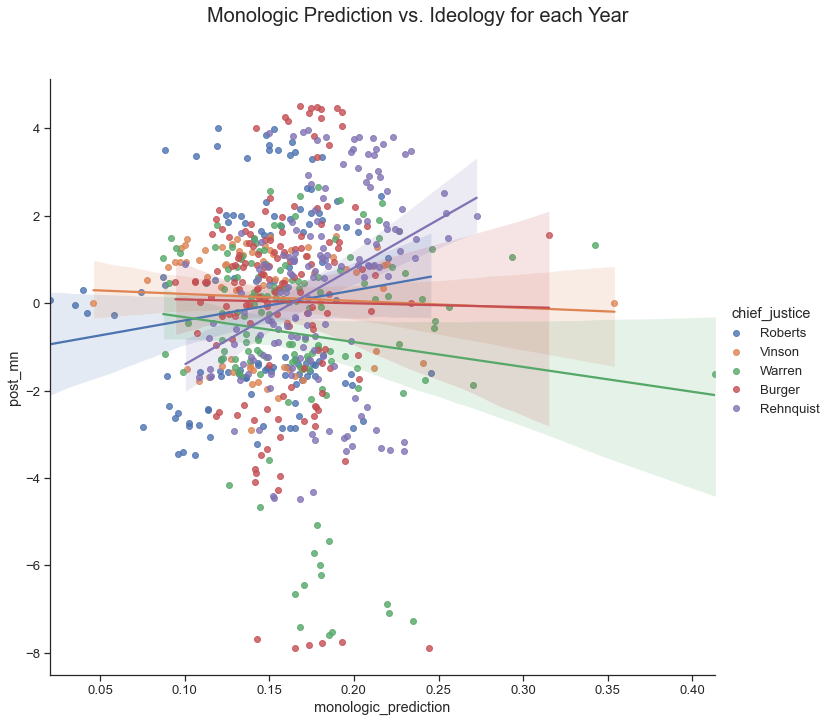

In [144]:
import seaborn as sns

g = sns.lmplot('monologic_prediction', 'post_mn', data=year_monologic_ideology, hue='chief_justice', height = 10, fit_reg=True, legend_out=True)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('Monologic Prediction vs. Ideology for each Year', fontsize = 20);
plt.show()


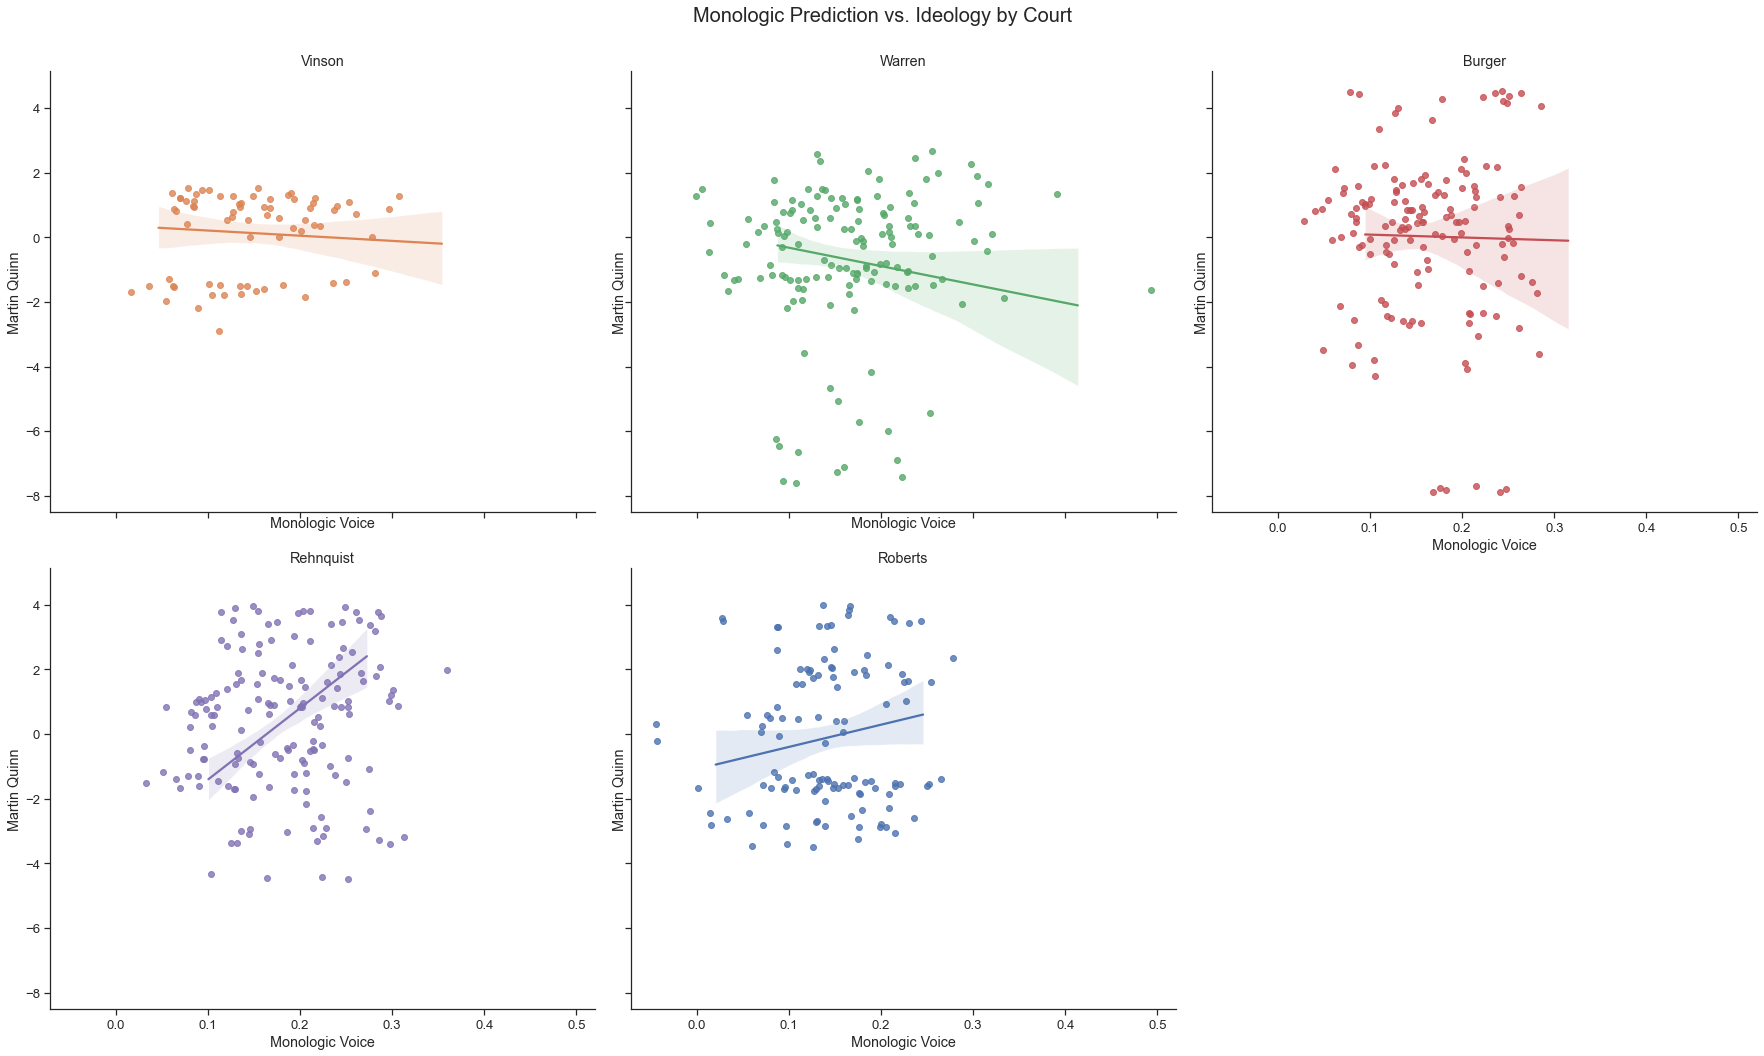

In [145]:
g = sns.lmplot(x="monologic_prediction", 
               y="post_mn", 
               hue="chief_justice", 
               col="chief_justice", 
               col_wrap=3,
               col_order=["Vinson", "Warren", "Burger", "Rehnquist", "Roberts"],
               data=year_monologic_ideology, 
               #height=6, 
               #aspect=, 
               x_jitter=.1)

g.set_titles(col_template="{col_name}")
g.set(xlabel='Monologic Voice', ylabel='Martin Quinn')
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Monologic Prediction vs. Ideology by Court', fontsize = 20)
g.fig.set_figheight(15)
g.fig.set_figwidth(25)
#plt.savefig(output_path + '/fightin_words');

## Salience

In [146]:
salience_df = pd.read_csv("/Users/rosamondthalken/Documents/Projects/SupremeCourt/SupremeCourtPython/Data/salience.csv")

In [147]:
opinion_monologic = df_filtered.groupby(['case'], as_index=False)['monologic_prediction'].mean()

In [148]:
opinion_monologic

,case,monologic_prediction
0,14 Penn Plaza LLC v. Pyett,0.164865
1,149 Madison Ave. Corp. v. Asselta,0.125000
2,324 Liquor Corp. v. Duffy,0.147465
3,"44 Liquormart, Inc. v. Rhode Island",0.254950
4,62 Cases of Jam v. United States,0.221053
...,...,...
7289,Zuber v. Allen,0.143345
7290,Zuni Public School Dist. v. Dept. of Educ.,0.201923
7291,Zurcher v. Stanford Daily,0.141732
7292,Zwickler v. Koota,0.221239


In [149]:
salience_df = pd.read_csv("/Users/rosamondthalken/Documents/Projects/SupremeCourt/SupremeCourtPython/Data/all_metadata.csv")

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [152]:
df_for_merging = salience_df[['case_name', 'salience.est']]

In [154]:
df_for_merging = df_for_merging.drop_duplicates()

In [157]:
salience_monologic_opinion = opinion_monologic.merge(df_for_merging, left_on = "case", right_on = "case_name")

In [158]:
opinion_monologic_array = salience_monologic_opinion.monologic_prediction.values.reshape(-1, 1)
opinion_salience_array = salience_monologic_opinion["salience.est"].values.reshape(-1, 1)

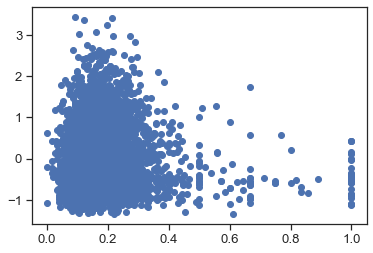

In [160]:
plt.scatter(opinion_monologic_array, opinion_salience_array);
#plt.plot(opinion_monologic_array, opinion_salience_array, color='blue', linewidth=3)

Coefficients: 
 [[-0.07482487]]
Mean squared error: 0.54
Coefficient of determination: -5.04


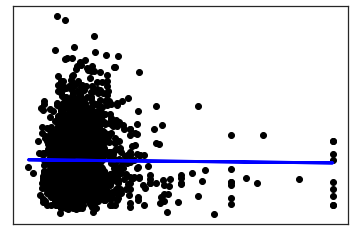

In [161]:
X_train, X_test, y_train, y_test = train_test_split(opinion_monologic_array, opinion_salience_array, test_size=0.33, random_state=42)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
monologic_ideol_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, monologic_ideol_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(X_test, monologic_ideol_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, monologic_ideol_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()